In [1]:
import tqdm
import mlmi
import mlmi3
import numpy as np
import scipy.stats
import pandas as pd
import sklearn
import sklearn.covariance
import networkx as nx
import matplotlib.pyplot as plt
% matplotlib inline
import seaborn as sns
sns.set_style('ticks')
palette = sns.color_palette("RdBu_r", n_colors=25)
import plotly
plotly.offline.init_notebook_mode(connected=True)

In [2]:
sns.set_palette(palette)

## Multivariate Gaussian

In [3]:
pre = [[1,   0.5,    0],
       [0.5,   1, -0.4],
       [0,  -0.4,    1]]
cov = np.linalg.inv(pre)
print(np.array(pre))
X = scipy.stats.multivariate_normal(mean=[0, 0, 0], cov=cov).rvs(3000)

[[ 1.   0.5  0. ]
 [ 0.5  1.  -0.4]
 [ 0.  -0.4  1. ]]


In [4]:
mi = np.zeros([3, 3])
cmi = np.zeros([3, 3])
for i, j in tqdm.tqdm([(0, 1), (0, 2), (1, 2)]):
    mi[i, j] = mlmi.mutual_information(X[:, i].reshape(-1, 1), X[:, j].reshape(-1, 1), n_b=200, maxiter=1000)
    mask = (np.arange(3) != i) & (np.arange(3) != j)
    mi_xz = mlmi.mutual_information(X[:, i].reshape(-1, 1), X[:, mask], n_b=200, maxiter=1000)
    mi_yz = mlmi.mutual_information(X[:, j].reshape(-1, 1), X[:, mask], n_b=200, maxiter=1000)
    mi_xyz = mlmi3.mutual_information(X[:, i].reshape(-1, 1), X[:, j].reshape(-1, 1), X[:, mask], n_b=200, maxiter=1000)
    cmi[i, j] = mi_xyz - (mi_xz + mi_yz)

cmi

100%|██████████| 3/3 [01:40<00:00, 33.11s/it]


array([[ 0.        ,  0.14713989, -0.00345142],
       [ 0.        ,  0.        ,  0.08209851],
       [ 0.        ,  0.        ,  0.        ]])

In [5]:
model = sklearn.covariance.GraphLasso(alpha=0.3)
model.fit(X)

GraphLasso(alpha=0.3, assume_centered=False, enet_tol=0.0001, max_iter=100,
      mode='cd', tol=0.0001, verbose=False)

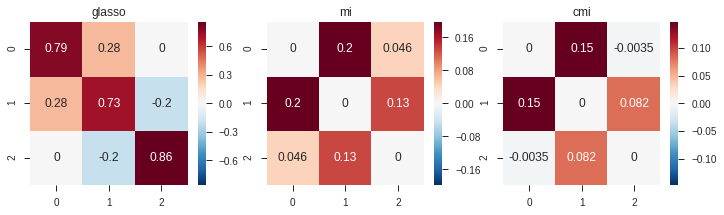

In [6]:
f, axes = plt.subplots(1, 3, figsize=[12, 3])
axes[0].set_title('glasso')
axes[1].set_title('mi')
axes[2].set_title('cmi')
sns.heatmap(model.precision_, annot=True, ax=axes[0], center=0)#, cmap=palette)
sns.heatmap(mi + np.transpose(mi), annot=True, ax=axes[1], center=0)#, cmap=palette)
sns.heatmap(cmi + np.transpose(cmi), annot=True, ax=axes[2], center=0)#, cmap=palette)
plt.savefig('cmi.png', dpi=120)

## Multivariate Gaussian Mixuture

In [7]:
X1 = scipy.stats.multivariate_normal(mean=[-5,  0,  0], cov=np.eye(3)).rvs(500)
X2 = scipy.stats.multivariate_normal(mean=[+5,  0,  0], cov=np.eye(3)).rvs(500)
X3 = scipy.stats.multivariate_normal(mean=[ 0, 10,  0], cov=np.eye(3)).rvs(500)
X = np.vstack([X1, X2, X3])
X.shape

(1500, 3)

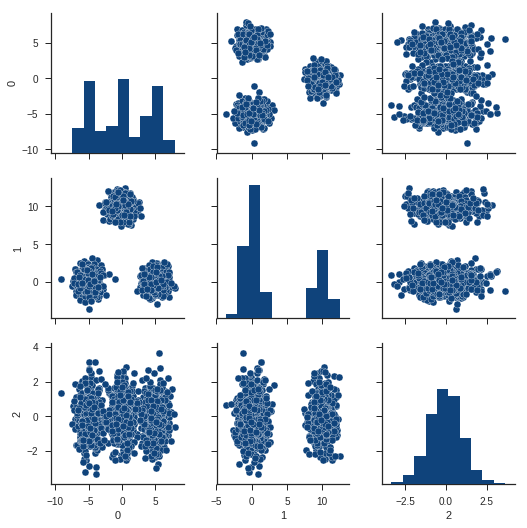

In [8]:
sns.pairplot(pd.DataFrame(X))

In [9]:
trace = plotly.graph_objs.Scatter3d(x=X[:, 0], y=X[:, 1], z=X[:, 2], mode='markers', marker=dict(size='2', line = dict(width = 1)))
plotly.offline.iplot([trace])

In [10]:
mi = np.zeros([3, 3])
cmi = np.zeros([3, 3])
for i, j in tqdm.tqdm([(0, 1), (0, 2), (1, 2)]):
    mi[i, j] = mlmi.mutual_information(X[:, i].reshape(-1, 1), X[:, j].reshape(-1, 1), n_b=200, maxiter=100000)
    mask = (np.arange(3) != i) & (np.arange(3) != j)
    mi_xz = mlmi.mutual_information(X[:, i].reshape(-1, 1), X[:, mask], n_b=200, maxiter=100000)
    mi_yz = mlmi.mutual_information(X[:, j].reshape(-1, 1), X[:, mask], n_b=200, maxiter=100000)
    mi_xyz = mlmi3.mutual_information(X[:, i].reshape(-1, 1), X[:, j].reshape(-1, 1), X[:, mask], n_b=200, maxiter=100000)
    cmi[i, j] = mi_xyz - (mi_xz + mi_yz)

cmi

100%|██████████| 3/3 [01:04<00:00, 22.00s/it]


array([[ 0.        ,  0.60606119,  0.00603842],
       [ 0.        ,  0.        ,  0.00182831],
       [ 0.        ,  0.        ,  0.        ]])

In [14]:
model = sklearn.covariance.GraphLasso(alpha=0.1)
model.fit(X)

GraphLasso(alpha=0.1, assume_centered=False, enet_tol=0.0001, max_iter=100,
      mode='cd', tol=0.0001, verbose=False)

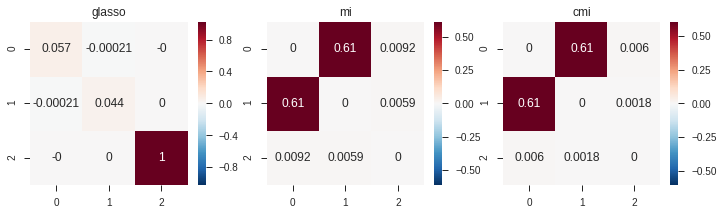

In [15]:
f, axes = plt.subplots(1, 3, figsize=[12, 3])
axes[0].set_title('glasso')
axes[1].set_title('mi')
axes[2].set_title('cmi')
sns.heatmap(model.precision_, annot=True, ax=axes[0], center=0)#, cmap=palette)
sns.heatmap(mi + np.transpose(mi), annot=True, ax=axes[1], center=0)#, cmap=palette)
sns.heatmap(cmi + np.transpose(cmi), annot=True, ax=axes[2], center=0)#, cmap=palette)
plt.savefig('cmi2.png', dpi=120)